In [1]:
# Imports
import pandas as pd
import datetime as dt

import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt

import tensorflow as tf
from keras.utils import to_categorical
from tensorflow.keras import layers, models, regularizers, callbacks
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
from imblearn.over_sampling import SMOTE 

In [2]:
def clean_up_observations_and_add_rain_class(atg_obs_selected):
    no_erros_obs = atg_obs_selected.loc[(atg_obs_selected['Rain']!='M')&(atg_obs_selected['Temperature']!='M')&(atg_obs_selected['Pressure']!='M')&(atg_obs_selected['Relhum']!='M')&(atg_obs_selected['Relhum']!='0.00.')].copy()

    no_erros_obs['datetime_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_UTC']).tz_localize('UTC').tz_convert('US/Pacific')
    no_erros_obs['Date_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).date
    no_erros_obs['Time_PST'] = pd.DatetimeIndex(no_erros_obs['datetime_PST']).time
    no_erros_obs['Rain'] = no_erros_obs['Rain'].astype(float)
    no_erros_obs['Temperature'] = no_erros_obs['Temperature'].astype(float)
    no_erros_obs['Pressure'] = no_erros_obs['Pressure'].astype(float)
    no_erros_obs['Relhum'] = no_erros_obs['Relhum'].astype(float)

    first_obs_each_period = no_erros_obs.resample(on='datetime_UTC', rule='1h')
    summed_rain_each_period = first_obs_each_period['Rain'].sum()

    lightrainfall_times = summed_rain_each_period[(summed_rain_each_period<=0.08)&(summed_rain_each_period>0.0)]
    heavyrainfall_times = summed_rain_each_period[(summed_rain_each_period>0.08)]

    summed_rain_each_period.loc[lightrainfall_times.index] = 1
    summed_rain_each_period.loc[heavyrainfall_times.index] = 2

    # Extract Date, Time, Temperature, SumRain into data array
    atg_obs_necessary = pd.DataFrame()
    atg_obs_necessary['date'] = first_obs_each_period['Date_PST'].first()
    atg_obs_necessary['time'] = first_obs_each_period['Time_PST'].first()
    atg_obs_necessary['temperature'] = first_obs_each_period['Temperature'].first()
    atg_obs_necessary['pressure'] = first_obs_each_period['Pressure'].first()
    atg_obs_necessary['relhum'] = first_obs_each_period['Relhum'].first()
    atg_obs_necessary['rainfall_type'] = summed_rain_each_period

    atg_obs_necessary = atg_obs_necessary.dropna()
    data_arr = atg_obs_necessary.values

    return atg_obs_necessary, data_arr

In [3]:
atg_obs = pd.read_csv('../../Downloads/LFEM_data-.csv', low_memory=False, skiprows=1)
atg_obs.insert(0, 'datetime_UTC', pd.to_datetime(atg_obs['Date'] + atg_obs['Time'], format='%Y-%m-%d%H:%M'))

In [4]:
atg_obs_selected = atg_obs.copy() # Selecting dates
atg_obs_selected = atg_obs_selected.loc[(atg_obs['datetime_UTC']>=dt.datetime(2023,5,1))]

In [5]:
# Extract Date, Time, Temperature, SumRain into data array
atg_obs_necessary, data_arr = clean_up_observations_and_add_rain_class(atg_obs_selected)
atg_obs_necessary

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-01 17:00:00,2023-05-01,10:14:00,54.6,1007.6,61.8,0.0
2023-05-01 18:00:00,2023-05-01,11:00:00,55.2,1007.5,62.4,0.0
2023-05-01 19:00:00,2023-05-01,12:00:00,55.0,1007.4,63.7,0.0
2023-05-01 20:00:00,2023-05-01,13:00:00,56.4,1006.8,63.2,0.0
2023-05-01 21:00:00,2023-05-01,14:00:00,56.8,1006.9,63.1,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,06:00:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,07:00:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,08:00:00,52.4,1017.0,69.1,0.0


In [6]:
def select_times_around_specific_events(atg_obs_necessary, event, num_days_around):
    notable_event_times = atg_obs_necessary.loc[atg_obs_necessary['rainfall_type']>=event].index

    relevant_events = pd.DataFrame()
    for event_time in notable_event_times:
        start_time = event_time-pd.Timedelta(days=num_days_around)
        end_time = event_time+pd.Timedelta(days=num_days_around)
        time_around_event = atg_obs_necessary.loc[start_time:end_time].copy()
        relevant_events = pd.concat([relevant_events, time_around_event]).drop_duplicates()
    
    return relevant_events

In [7]:
relevant_events = select_times_around_specific_events(atg_obs_necessary, 2, 30)
relevant_events

,date,time,temperature,pressure,relhum,rainfall_type
datetime_UTC,,,,,,
2023-05-01 17:00:00,2023-05-01,10:14:00,54.6,1007.6,61.8,0.0
2023-05-01 18:00:00,2023-05-01,11:00:00,55.2,1007.5,62.4,0.0
2023-05-01 19:00:00,2023-05-01,12:00:00,55.0,1007.4,63.7,0.0
2023-05-01 20:00:00,2023-05-01,13:00:00,56.4,1006.8,63.2,0.0
2023-05-01 21:00:00,2023-05-01,14:00:00,56.8,1006.9,63.1,0.0
...,...,...,...,...,...,...
2024-05-23 13:00:00,2024-05-23,06:00:00,50.5,1016.5,77.4,0.0
2024-05-23 14:00:00,2024-05-23,07:00:00,51.7,1016.8,74.0,0.0
2024-05-23 15:00:00,2024-05-23,08:00:00,52.4,1017.0,69.1,0.0


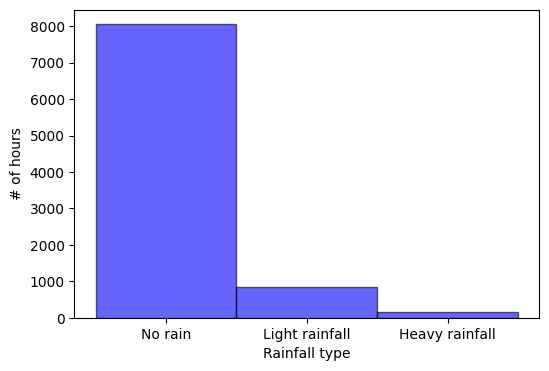

(array([8050,  843,  148]), array([0., 1., 2., 3.]))

In [8]:
rain_counts, classes = np.histogram(relevant_events['rainfall_type'].values, bins=np.arange(0,relevant_events['rainfall_type'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,relevant_events['rainfall_type'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,relevant_events['rainfall_type'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [9]:
def get_processed_df_from_data(dataset):
    date_objs = pd.to_datetime(dataset['date'], format="%Y-%m-%d")
    time_objs = pd.to_datetime(dataset['time'], format='%H:%M:%S')

    months = pd.DatetimeIndex(date_objs).month
    hours = pd.DatetimeIndex(time_objs).hour

    processed_df = pd.DataFrame()
    processed_df['months_from_july'] = months
    # processed_df['time_of_day'] = ((hours-4)%24) / 6

    vals = dataset['temperature']
    processed_df['feature_1'] = vals.values

    vals = dataset['relhum']
    processed_df['feature_2'] = vals.values

    vals = dataset['pressure']
    processed_df['feature_3'] = vals.values

    processed_df['class'] = dataset['rainfall_type'].values
    return processed_df

In [10]:
def create_oversampled_df(processed_df):
    num_zeros = processed_df[processed_df['class']==0].shape[0]

    zeros_samps = processed_df[processed_df['class']==0].copy()
    dupl_processed_df = zeros_samps
    for group in np.arange(1, 3):
        under_group_samps = processed_df[processed_df['class']==group].copy()
        group_samps = under_group_samps.sample(n=(num_zeros-len(under_group_samps)), replace=True, random_state=42)
        
        np.random.seed(1)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_1'] = group_samps['feature_1']+noise

        np.random.seed(2)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_2'] = group_samps['feature_2']+noise

        np.random.seed(3)
        noise = np.random.normal(0,1,(num_zeros-len(under_group_samps)))
        group_samps['feature_3'] = group_samps['feature_3']+noise

        dupl_processed_df = pd.concat([dupl_processed_df, under_group_samps, group_samps])

    return dupl_processed_df

In [11]:
raw_df_train_val, raw_under_df_test = train_test_split(relevant_events,random_state=42,test_size=0.2)
raw_under_df_train, raw_under_df_val = train_test_split(raw_df_train_val,random_state=42,test_size=0.25)

In [12]:
under_sam_reltimes_tr = get_processed_df_from_data(raw_under_df_train)
processed_df_train = create_oversampled_df(under_sam_reltimes_tr)
processed_df_train

,months_from_july,feature_1,feature_2,feature_3,class
0,4,67.000000,20.000000,1015.200000,0.0
1,3,49.900000,82.300000,1014.600000,0.0
3,11,41.000000,78.200000,1019.400000,0.0
4,5,51.900000,91.800000,999.600000,0.0
5,10,44.600000,84.700000,1020.000000,0.0
...,...,...,...,...,...
1111,1,35.523852,99.710609,991.895927,2.0
45,9,60.217410,67.454378,1011.630128,2.0
1889,1,44.678630,81.584220,996.599854,2.0
433,12,46.764744,83.718714,1004.100650,2.0


In [13]:
processed_df_val = get_processed_df_from_data(raw_under_df_val)
# processed_df_val = create_oversampled_df(under_sam_reltimes_va)
processed_df_val

,months_from_july,feature_1,feature_2,feature_3,class
0,4,46.6,81.5,1017.3,0.0
1,7,68.6,56.7,1015.3,0.0
2,8,71.5,54.9,1012.2,0.0
3,7,76.1,45.3,1014.7,0.0
4,10,67.2,41.4,1014.0,0.0
...,...,...,...,...,...
1803,6,53.8,81.3,1013.5,1.0
1804,10,44.1,58.8,1030.5,0.0
1805,8,63.3,81.5,1016.7,0.0
1806,5,52.2,77.0,1014.7,0.0


In [14]:
processed_df_train.shape, processed_df_val.shape

((14565, 5), (1808, 5))

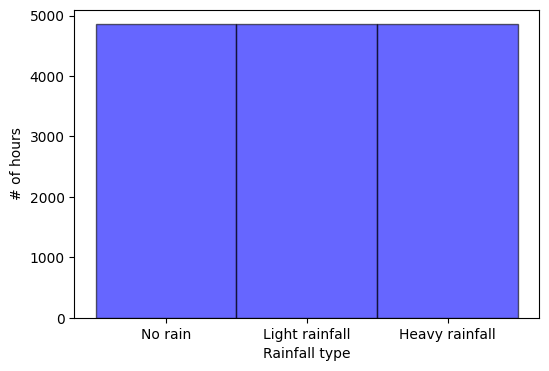

(array([4855, 4855, 4855]), array([0., 1., 2., 3.]))

In [15]:
rain_counts, classes = np.histogram(processed_df_train['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

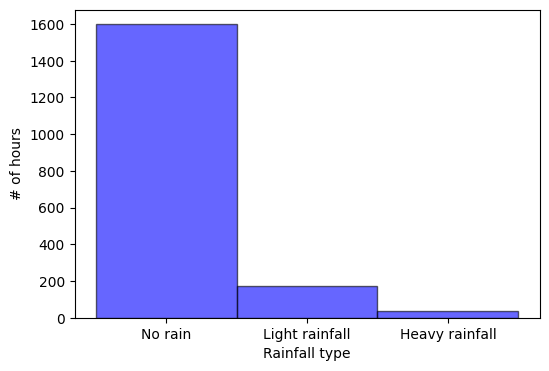

(array([1598,  172,   38]), array([0., 1., 2., 3.]))

In [16]:
rain_counts, classes = np.histogram(processed_df_val['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
rain_counts, classes

In [17]:
processed_data_train = processed_df_train.values.astype(float)
processed_data_train.shape

(14565, 5)

In [18]:
processed_data_val = processed_df_val.values.astype(float)
processed_data_val.shape

(1808, 5)

In [19]:
x_data_train = processed_data_train[:, :processed_data_train.shape[1]-1]
y_train_labs = processed_data_train[:, processed_data_train.shape[1]-1:]
y_data_train = to_categorical(y_train_labs, 3)
print(x_data_train[0], y_data_train[0])

[   4.    67.    20.  1015.2] [1. 0. 0.]


In [20]:
x_data_val = processed_data_val[:, :processed_data_val.shape[1]-1]
y_val_labs = processed_data_val[:, processed_data_val.shape[1]-1:]
y_data_val = to_categorical(y_val_labs, 3)
print(x_data_val[0], y_data_val[0])

[   4.    46.6   81.5 1017.3] [1. 0. 0.]


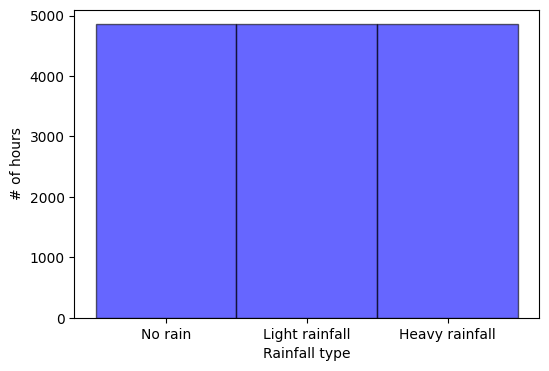

(array([4855, 4855, 4855]), array([0., 1., 2., 3.]))

In [21]:
rain_counts, classes = np.histogram(y_train_labs, bins=np.arange(0,y_train_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_train_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_train_labs.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

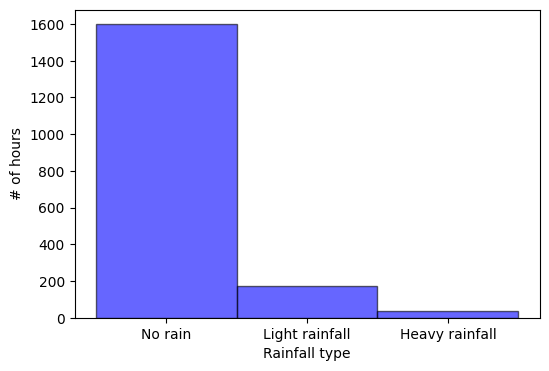

(array([1598,  172,   38]), array([0., 1., 2., 3.]))

In [22]:
rain_counts, classes = np.histogram(y_val_labs, bins=np.arange(0,y_val_labs.max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,y_val_labs.max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xticks(ticks=np.arange(0,y_val_labs.max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(x_data_train)
X_val_scaled = scaler.transform(x_data_val)

# Define the model
model = models.Sequential()

# Input layer
model.add(layers.Input(shape=(x_data_train.shape[1],)))

# Hidden layers
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(3, activation='softmax'))  # Softmax for multiclass classification

# Compile the model
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Learning rate reduction callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001)

# Early stopping callback
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=25, restore_best_weights=True)

# Print model summary
model.summary()

2024-06-02 12:08:14.541774: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-06-02 12:08:14.541951: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               640       
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 128)               16512     
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                             

In [24]:
X_train_scaled.shape, y_data_train.shape

((14565, 4), (14565, 3))

In [25]:
X_val_scaled.shape, y_data_val.shape

((1808, 4), (1808, 3))

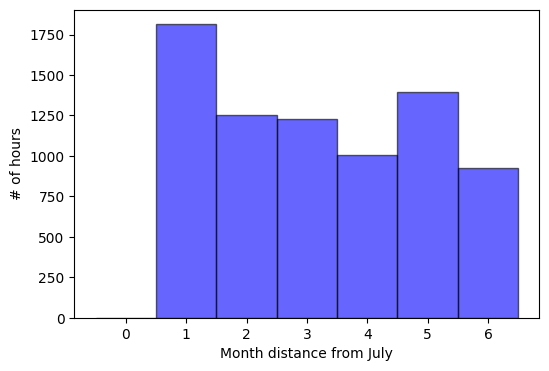

(array([   0, 1813, 1251, 1231, 1006, 1393,  923]),
 array([0, 1, 2, 3, 4, 5, 6, 7]))

In [26]:
binwidth = 1
rain_counts, classes = np.histogram(x_data_train[:,0], bins=np.arange(0,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Month distance from July')
plt.show()
rain_counts, classes

In [27]:
X_train_scaled

array([[-0.68960412,  1.72043071, -4.08153429,  0.84219261],
       [-0.93919619, -0.22619731,  0.07515909,  0.76024757],
       [ 1.05754036, -1.23935459, -0.19839537,  1.41580785],
       ...,
       [-1.43838033, -0.82058708,  0.02740185, -1.69812341],
       [ 1.30713243, -0.5831082 ,  0.16981655, -0.67370176],
       [ 1.30713243, -0.20070829,  0.88944971,  0.23693357]])

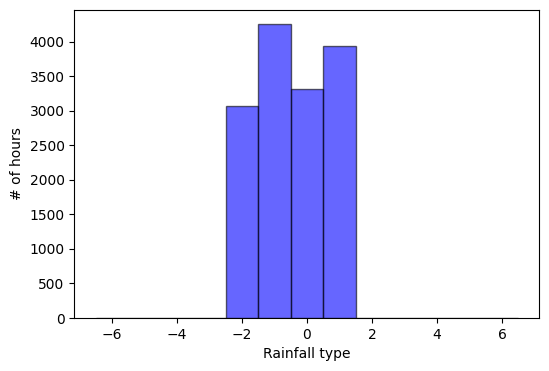

(array([   0,    0,    0,    0, 3064, 4249, 3313, 3939,    0,    0,    0,
           0,    0]),
 array([-6, -5, -4, -3, -2, -1,  0,  1,  2,  3,  4,  5,  6,  7]))

In [28]:
binwidth = 1
rain_counts, classes = np.histogram(X_train_scaled[:,0], bins=np.arange(-6,7+binwidth,binwidth))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(-6,7,binwidth), width=binwidth, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.ylabel('# of hours')
plt.xlabel('Rainfall type')
plt.show()
rain_counts, classes

In [29]:
scaler.mean_, scaler.scale_

(array([   6.76292482,   51.88701241,   81.17352496, 1009.03348166]),
 array([ 4.00653756,  8.78442094, 14.9878748 ,  7.32198109]))

In [30]:
# Train the Model:
history = model.fit(
    X_train_scaled, y_data_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_val_scaled, y_data_val),
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/100


2024-06-02 12:08:15.182580: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-06-02 12:08:15.472645: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


456/456 [==============================] - ETA: 0s - loss: 0.9868 - accuracy: 0.6406

2024-06-02 12:08:23.683191: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


456/456 [==============================] - 9s 18ms/step - loss: 0.9868 - accuracy: 0.6406 - val_loss: 0.9089 - val_accuracy: 0.6836 - lr: 0.0010
Epoch 2/100
456/456 [==============================] - 8s 17ms/step - loss: 0.8398 - accuracy: 0.6695 - val_loss: 0.8007 - val_accuracy: 0.7002 - lr: 0.0010
Epoch 3/100
456/456 [==============================] - 14s 31ms/step - loss: 0.7876 - accuracy: 0.6834 - val_loss: 0.8071 - val_accuracy: 0.6759 - lr: 0.0010
Epoch 4/100
456/456 [==============================] - 7s 14ms/step - loss: 0.7535 - accuracy: 0.6969 - val_loss: 0.8085 - val_accuracy: 0.6648 - lr: 0.0010
Epoch 5/100
456/456 [==============================] - 7s 15ms/step - loss: 0.7304 - accuracy: 0.7087 - val_loss: 0.7303 - val_accuracy: 0.7080 - lr: 0.0010
Epoch 6/100
456/456 [==============================] - 7s 14ms/step - loss: 0.7108 - accuracy: 0.7164 - val_loss: 0.7442 - val_accuracy: 0.6952 - lr: 0.0010
Epoch 7/100
456/456 [==============================] - 7s 16ms/step -

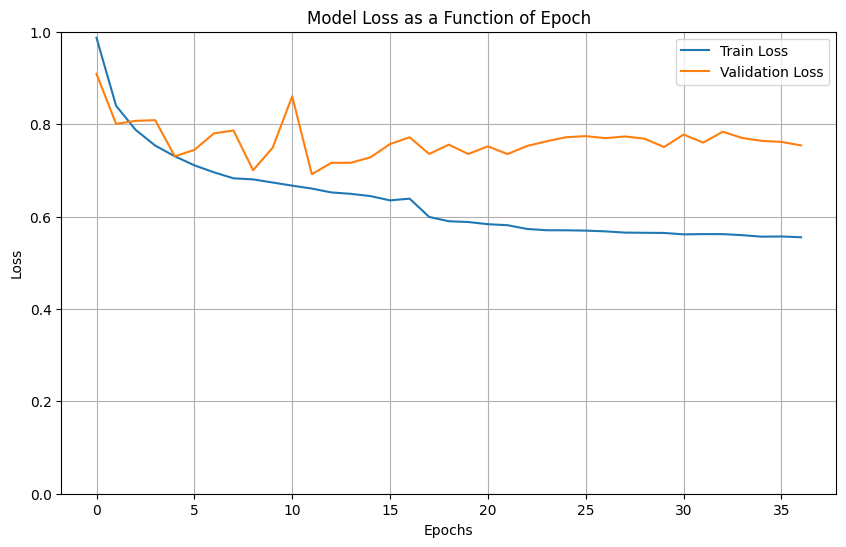

In [31]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)
plt.title('Model Loss as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

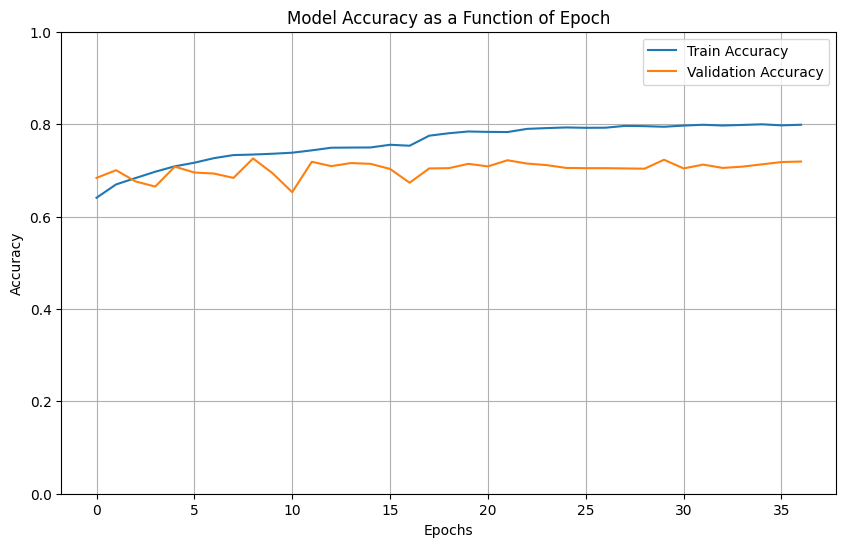

In [32]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.title('Model Accuracy as a Function of Epoch')
plt.legend()
plt.grid(True)
plt.show()

In [33]:
# Evaluation (Is it worth, the loss is quite high suggesting that either the model architecture is quite poor (likely) or 
# that we need to better preprocess our data such as rain (also likely))

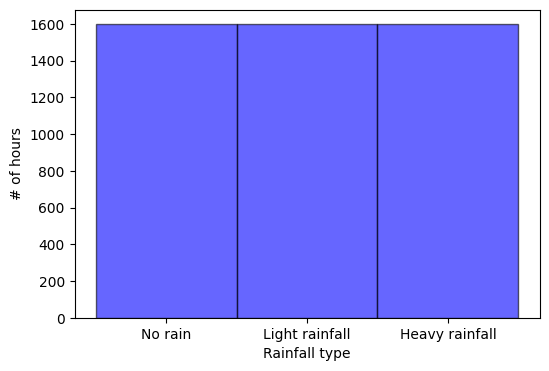

[1597 1597 1597] [0. 1. 2. 3.]
[   6.    68.9   61.3 1011.2] [1. 0. 0.]


In [34]:
under_sam_reltimes_te = get_processed_df_from_data(raw_under_df_test)
processed_df_test = create_oversampled_df(under_sam_reltimes_te)

rain_counts, classes = np.histogram(processed_df_test['class'].values, bins=np.arange(0,processed_df_train['class'].max()+2))

plt.figure(figsize=(6,4))
plt.bar(x=np.arange(0,processed_df_train['class'].max()+1), width=1, height=rain_counts, facecolor='blue', edgecolor='k', alpha=0.6)
plt.xticks(ticks=np.arange(0,processed_df_train['class'].max()+1), labels=['No rain', 'Light rainfall', 'Heavy rainfall'])
plt.xlabel('Rainfall type')
plt.ylabel('# of hours')
plt.show()
print(rain_counts, classes)

processed_data_test = processed_df_test.values.astype(float)
x_data_test = processed_data_test[:, :processed_data_test.shape[1]-1]
y_test_labs = processed_data_test[:, processed_data_test.shape[1]-1:]
y_data_test = to_categorical(y_test_labs, 3)
print(x_data_test[0], y_data_test[0])

In [35]:
scaler.mean_, scaler.scale_

(array([   6.76292482,   51.88701241,   81.17352496, 1009.03348166]),
 array([ 4.00653756,  8.78442094, 14.9878748 ,  7.32198109]))

In [36]:
x_data_test[-3]

array([   9.        ,   57.74895684,   84.35320012, 1006.69354402])

In [37]:
predict = model.predict(((x_data_test[-3] - scaler.mean_) / scaler.scale_).reshape(1,4))

2024-06-02 12:12:35.114410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 1s 640ms/step


In [38]:
np.argmax(predict)

1

In [39]:
X_test_scaled = scaler.transform(x_data_test)
predictions = model.predict(X_test_scaled)
model.evaluate(X_test_scaled, y_data_test, verbose=2)

150/150 [==============================] - 0s 2ms/step
150/150 - 1s - loss: 0.8508 - accuracy: 0.6978 - 1s/epoch - 9ms/step


[0.8507921099662781, 0.6977666616439819]

In [40]:
classes = np.argmax(predictions,axis=1)

In [41]:
classes

array([0, 0, 0, ..., 1, 2, 2])

In [42]:
test_when_x_is_one = x_data_test[np.where(classes==1)[0],:]

In [43]:
test_when_x_is_one[np.where(test_when_x_is_one[:,0]==5)[0],3]

array([1003.9       ,  999.3       , 1010.7       , 1011.1       ,
       1011.4       , 1010.6       , 1000.5       , 1017.7       ,
       1002.7       ,  998.7       , 1009.        ,  998.5       ,
       1011.5       , 1004.3       ,  997.5       ,  999.4       ,
       1017.6       , 1004.3       , 1005.2       , 1005.8       ,
       1006.4       , 1005.6       , 1005.8       , 1003.4       ,
       1018.4       ,  996.6       , 1008.        ,  996.8       ,
        998.2       , 1006.7       , 1007.23116365, 1020.17611078,
       1005.77358309, 1008.02971382,  998.08754313, 1007.79166291,
       1005.81134258, 1005.80892126, 1008.37729523, 1017.82529158,
       1004.04506198, 1006.0760685 , 1007.21481454, 1006.22163534,
       1006.22596675, 1018.8921189 ,  995.30195336, 1006.71842079,
        998.43915189,  998.65303779, 1006.79071677, 1019.39280517,
       1006.18059758,  998.28496406, 1019.02653585, 1007.12485682,
       1003.9351942 ,  997.7606248 , 1005.10624919, 1008.00841

In [44]:
test_when_x_is_one[:,3]

array([ 997.7       , 1013.5       , 1000.7       , ..., 1007.9374218 ,
        996.5154336 , 1006.69354402])

In [45]:
(test_when_x_is_one - scaler.mean_)/scaler.scale_

array([[-0.93919619, -0.28311626,  0.58223565, -1.54787093],
       [ 0.55835622,  0.58205175,  0.14855175,  0.61001501],
       [ 0.80794829,  0.74142481, -0.22508361, -1.13814575],
       ...,
       [ 0.80794829,  1.27952588,  0.47000584, -0.14969444],
       [-1.18878826, -0.26036858,  0.79164745, -1.70965315],
       [ 0.55835622,  0.66731142,  0.21214983, -0.31957712]])

In [46]:
test_predicts = model.predict((test_when_x_is_one - scaler.mean_)/scaler.scale_)

48/48 [==============================] - 0s 4ms/step


In [47]:
np.argmax(test_predicts,axis=1)

array([1, 1, 1, ..., 1, 1, 1])

Confusion Matrix:
[[1236  266   95]
 [ 267  886  444]
 [   1  375 1221]]


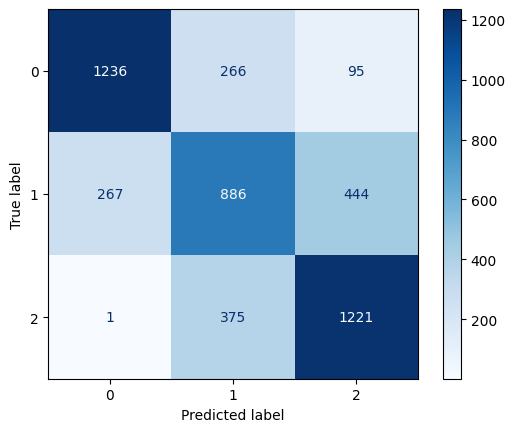

In [48]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Confusion Matrix:
[[1236  266   95]
 [ 267  886  444]
 [   1  375 1221]]


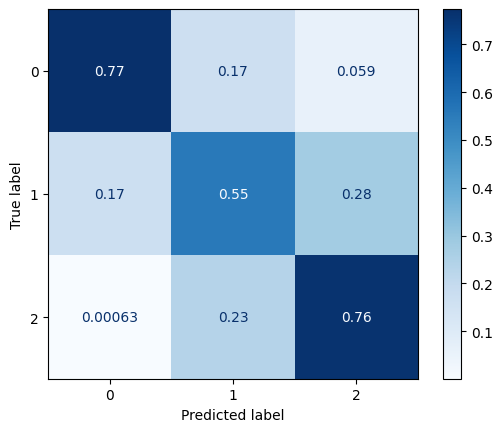

In [49]:
cm = confusion_matrix(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=(cm / np.sum(cm, axis=1).reshape(3, 1)), display_labels=[0, 1, 2])
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [50]:
f1_score(np.argmax(y_data_test, axis=1), np.argmax(predictions,axis=1), average=None)

array([0.79716221, 0.56722151, 0.72743521])

In [51]:
import calendar

5/5 [==============================] - 0s 3ms/step


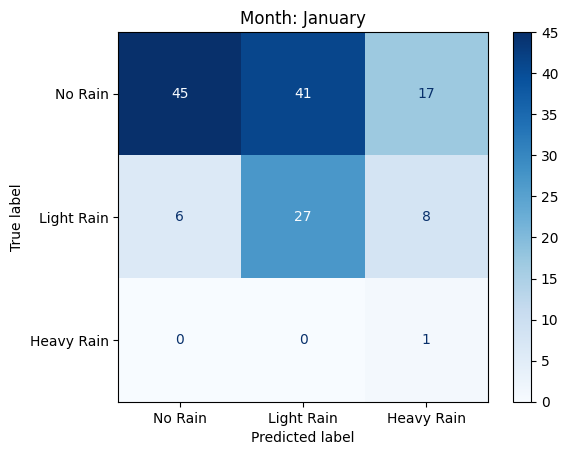

5/5 [==============================] - 0s 3ms/step


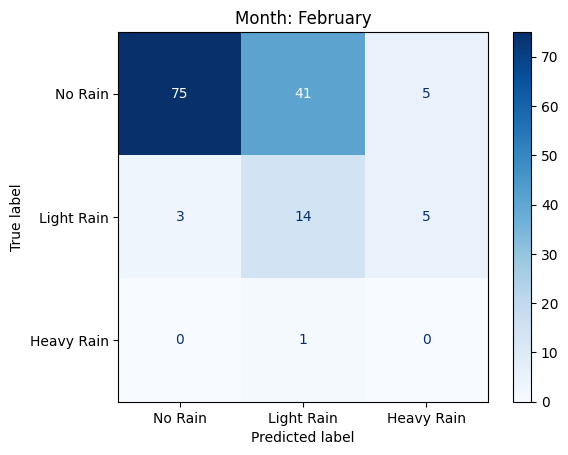

5/5 [==============================] - 0s 3ms/step


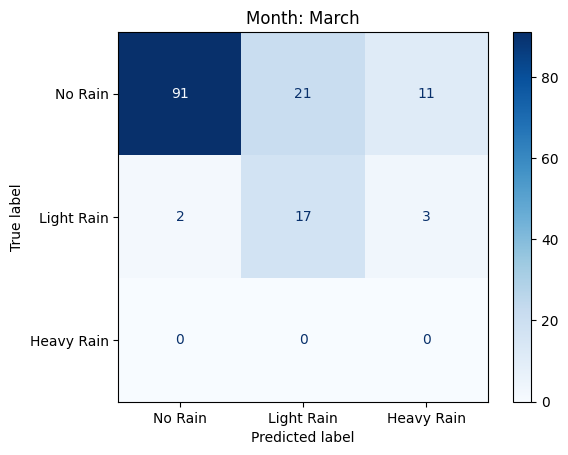

4/4 [==============================] - 0s 3ms/step


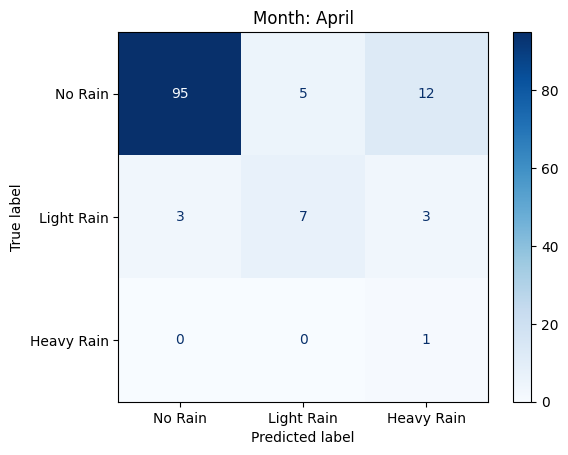

9/9 [==============================] - 0s 3ms/step


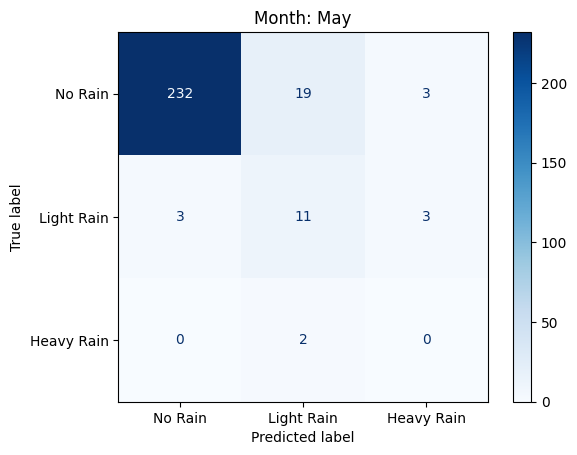

5/5 [==============================] - 0s 3ms/step


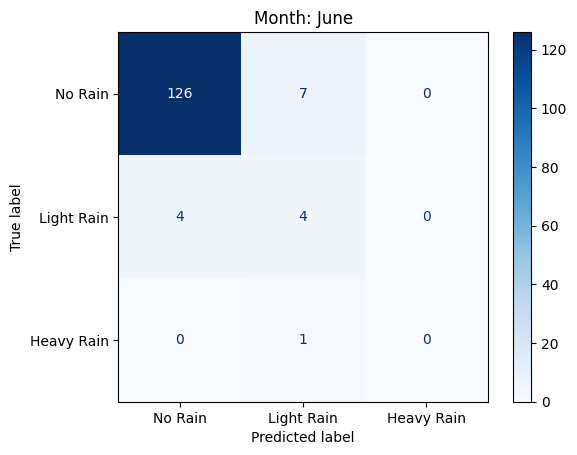

4/4 [==============================] - 0s 3ms/step


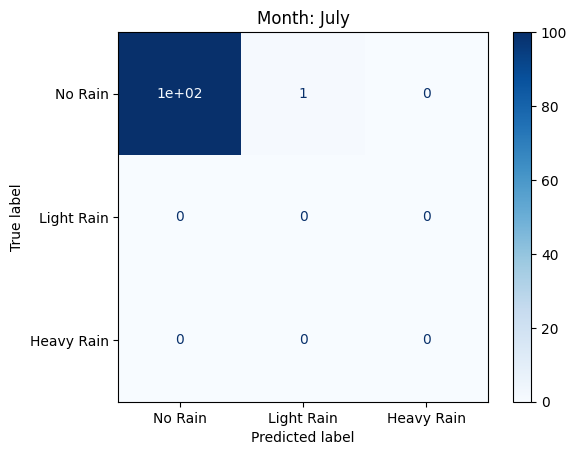

5/5 [==============================] - 0s 13ms/step


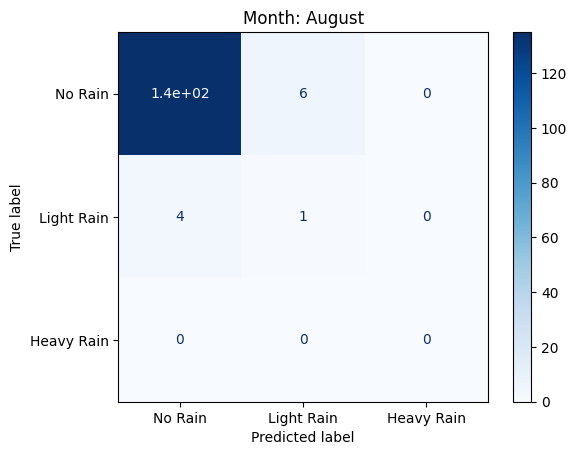

5/5 [==============================] - 0s 3ms/step


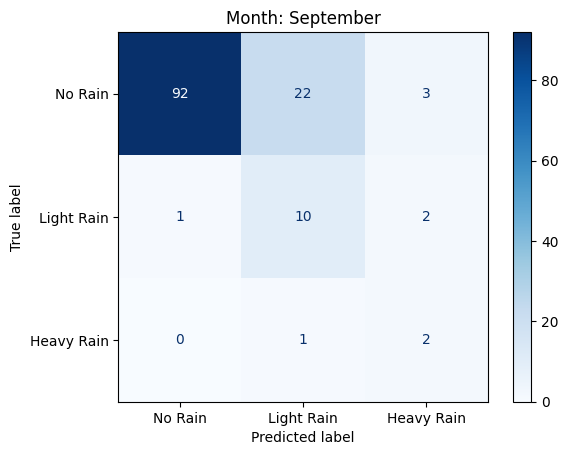

5/5 [==============================] - 0s 57ms/step


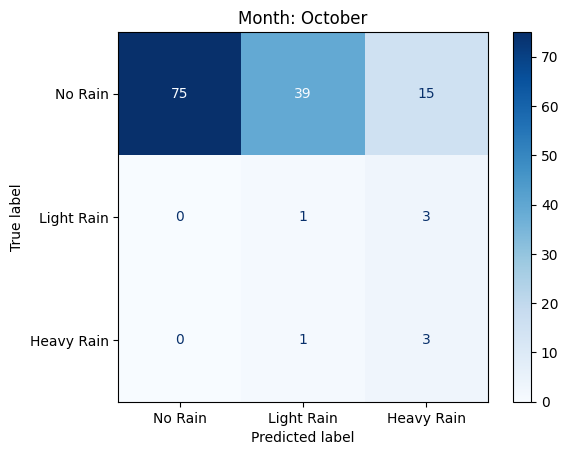

5/5 [==============================] - 0s 11ms/step


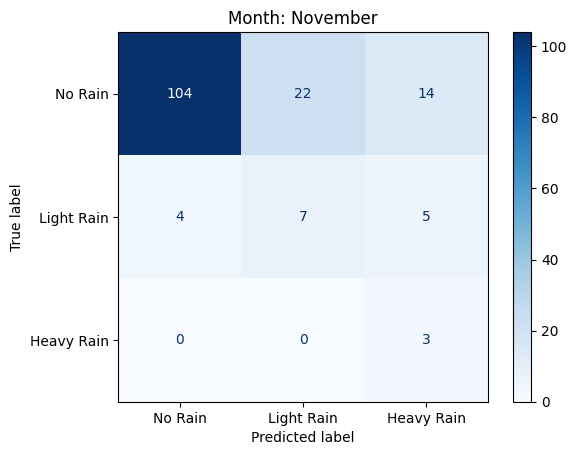

5/5 [==============================] - 0s 3ms/step


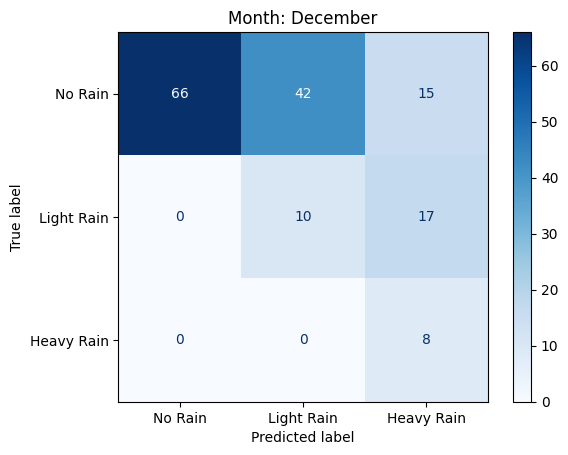

In [56]:
for month_num in np.arange(1, 13):
    test_data_sorted_month = raw_under_df_test.loc[(pd.DatetimeIndex(raw_under_df_test['date']).month==month_num), :].sort_index()
    # processed_test_sorted_month_balanced_raw = create_oversampled_df_from_raw(test_data_sorted_month).sort_index()
    processed_test_sorted_month = get_processed_df_from_data(test_data_sorted_month)
    processed_data_test_month = processed_test_sorted_month.values.astype(float)
    x_data_test_month = processed_data_test_month[:, :processed_data_test_month.shape[1]-1]
    y_test_labs_month = processed_data_test_month[:, processed_data_test_month.shape[1]-1:]
    y_data_test_month = to_categorical(y_test_labs_month, 3)

    X_test_scaled_month = scaler.transform(x_data_test_month)
    predictions_month = model.predict(X_test_scaled_month)

    cm = confusion_matrix(np.argmax(y_data_test_month, axis=1), np.argmax(predictions_month,axis=1))
    if cm.shape != (3,3):
        new_cm = np.zeros((3,3))
        new_cm[:2,:2] = cm
        cm = new_cm

    # Visualize the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Rain', 'Light Rain', 'Heavy Rain'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'Month: {calendar.month_name[month_num]}')
    plt.show()

In [ ]:
# # Assuming you have already trained your model
# model.save('../models/weather.h5')

In [ ]:
# # Convert the model to the TensorFlow Lite format without quantization
# converter = tf.lite.TFLiteConverter.from_keras_model(model)
# tflite_model = converter.convert()

# # Save the model to disk
# open("../models/weather.tflite", "wb").write(tflite_model)

# import os
# basic_model_size = os.path.getsize("../models/weather.tflite")
# print("Model is %d bytes" % basic_model_size)

INFO:tensorflow:Assets written to: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpicez_yi5/assets
Model is 171272 bytes


2024-05-30 14:49:06.907372: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-05-30 14:49:06.907393: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-05-30 14:49:06.909652: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpicez_yi5
2024-05-30 14:49:06.913527: I tensorflow/cc/saved_model/reader.cc:81] Reading meta graph with tags { serve }
2024-05-30 14:49:06.913537: I tensorflow/cc/saved_model/reader.cc:122] Reading SavedModel debug info (if present) from: /var/folders/qj/4txkrxcn2ld7mby9_6n6npnr0000gn/T/tmpicez_yi5
2024-05-30 14:49:06.919611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-05-30 14:49:06.922217: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2024-05-30 14:49:06.984788: I tensorflow/cc/saved_model/loader.

In [ ]:
# !echo "const unsigned char model[] = {" > ../arduino/model.h
# !cat ../models/weather.tflite | xxd -i      >> ../arduino/model.h
# !echo "};"                              >> ../arduino/model.h

In [ ]:
# import os
# model_h_size = os.path.getsize("../arduino/model.h")
# print(f"Header file, model.h, is {model_h_size:,} bytes.")
# print("\nOpen the side panel (refresh if needed). Double click model.h to download the file.")

Header file, model.h, is 1,056,212 bytes.

Open the side panel (refresh if needed). Double click model.h to download the file.
